## Анализ эмоциональной окраски текста твитов про Короновирус.





In [4]:
import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation

In [5]:
df = pd.read_csv('/content/tweets_coronavirus.csv', encoding='latin-1')
df.sample(5)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
401,4282,49234,"TORONTO, LAS VEGAS",16-03-2020,STAY SAFE YÃÂALL \r\r\nI DIDNÃÂT REALIZE H...,Positive
5604,10606,55558,"Mumbai, India",19-03-2020,When a family of 7 were detected with 19 in Ke...,Negative
2016,6251,51203,Search for a better life,17-03-2020,@YaHalaShow #??? #??? @citizenaccount @cnnarab...,Negative
11622,17894,62846,London,21-03-2020,How can companies send threatening letters lik...,Negative
11878,18213,63165,"Sydney, New South Wales",21-03-2020,Wow who would've ever thought supermarket shel...,Extremely Positive


Для каждого твитта указано:


*   UserName - имя пользователя, заменено на целое число для анонимности
*   ScreenName - отображающееся имя пользователя, заменено на целое число для анонимности
*   Location - местоположение
*   TweetAt - дата создания твитта
*   OriginalTweet - текст твитта
*   Sentiment - эмоциональная окраска твитта (целевая переменная)





Целевая переменная - `Sentiment`.

In [6]:
df['Sentiment'] = df['Sentiment'].apply(lambda s : 0 if 'Negative' in s else 1 )
balance = df['Sentiment'].value_counts()
float(balance[1]/balance.sum())

0.5395885659610095

Классы датасета сбалансированы.

In [ ]:
df = df.fillna('Unknown')

Заполнил пропуски в данных

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df.drop('Sentiment', axis=1), df['Sentiment'], test_size=0.3, random_state=0)

In [ ]:
from nltk.tokenize import TweetTokenizer
import nltk
from nltk.corpus import stopwords
from string import punctuation

nltk.download('stopwords')
stops = stopwords.words('english')

def custom_tokenizer(text):

  tknzr = TweetTokenizer()
  stops = stopwords.words('english')

  text = text.lower()
  tokens = tknzr.tokenize(text)
  for t in list(tokens):
    if t in stops:
      tokens.remove(t)
    elif t in punctuation:
      tokens.remove(t)
    elif (len(t)==1 and ord(t)>=128):
      tokens.remove(t)
    elif t.startswith('https://t.co'):
      tokens.remove(t)


  return tokens


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
custom_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext')

['sample', 'text', '@sample_text', '#sampletext']

Токенайзер прошел проверку на тренировочной строке и справился с разделением.

Далее, нужно обучить CountVectorizer на тренировочных и тестовых данных и в качестве токеназера буду использовать собственный токенайзер написанный выше.


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer


cv = CountVectorizer(tokenizer=custom_tokenizer)

cv.fit(X_train['OriginalTweet'])
train_count = cv.fit_transform(X_train['OriginalTweet'])
test_count = cv.transform(X_test['OriginalTweet'])


/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Использовать векторы 'train_count' и 'test_count' для обучения Логистической регрессии

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

lr_count = LogisticRegression()
lr_count.fit(train_count, y_train)
y_pred_train_count = lr_count.predict(train_count)
y_pred_test_count = lr_count.predict(test_count)

acc_train_count = accuracy_score(y_train, y_pred_train_count)
acc_test_count = accuracy_score(y_test, y_pred_test_count)


print('Точность CV на train:',acc_train_count, '\n',
      'Точность CV на test:', acc_test_count, '\n')

Точность CV на train: 0.9846646732165741 
 Точность CV на test: 0.8670520231213873 



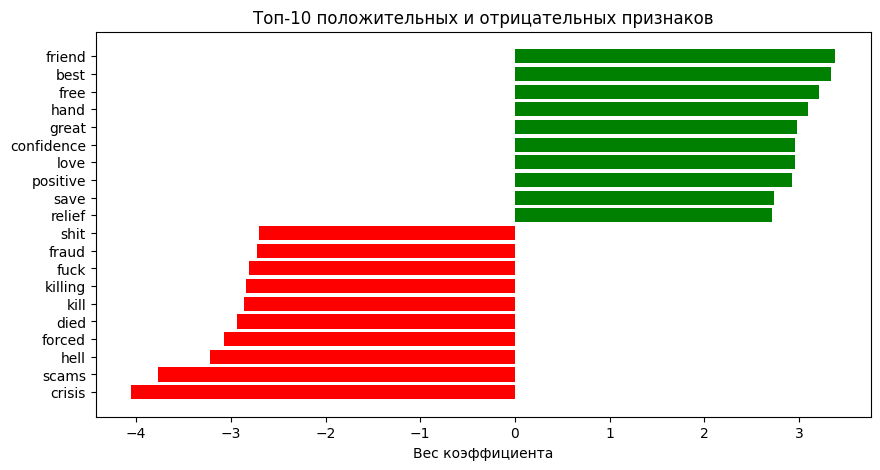

In [ ]:
feature_names = np.array(cv.get_feature_names_out())
coef = lr_count.coef_[0]

top_positive_indices = np.argsort(coef)[-10:]
top_negative_indices = np.argsort(coef)[:10]
top_features = np.concatenate([feature_names[top_negative_indices], feature_names[top_positive_indices]])
top_weights = np.concatenate([coef[top_negative_indices], coef[top_positive_indices]])

plt.figure(figsize=(10, 5))
plt.barh(top_features, top_weights, color=['red']*10 + ['green']*10)
plt.xlabel('Вес коэффициента')
plt.title('Топ-10 положительных и отрицательных признаков')
plt.show()

Визуализация для того как алгоритм определяет позитивные и негативные токен в твитах
